# Preparation

In [1]:
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from trafficSimulator import *
import matplotlib.pyplot as plt

pygame 2.0.1 (SDL 2.0.14, Python 3.6.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Simulation setup

### Simulation params setup

In [2]:
all_routes = [[0, 3], [0, 1], [2, 3], [2, 1]]

v_max = 15
s0 = 3
T = 1
b_max = 2.5
a_max = 1.5

vehicle_specs = {'v_max': v_max, # Desired speed
                 's0': s0, # Safe bumper-to-bumper distance
                 'T': T, # Time gap
                 'b_max': b_max, # Deceleartion
                 'a_max': a_max, # Acceleration
                }

vehicle_rate = 120
fast_track_factor, slow_track_factor = 1, 0.6
stop_distance = 40
wait_time = 1.5
vehicle_limit = 80

df = pd.DataFrame(columns=['Vehicle_label', 'Road_order', 
                           'Total_time', 'Leading_vehicles',
                           'Stopped_time', 'Stop_while_front'])

vehicle_preferences = dict(zip(range(vehicle_limit), 
                               [[0.25, 0.25, 0.25, 0.25]]*vehicle_limit))

### Topology setup

In [3]:
def parallel_line(current_coordinates, distance):
    """
    Returns the coordinate sets of lines that are parallel to the given line
    with the speicified distance
    
    Input:
        current_coordinates: two set of x and y coordinates that mark the start
                             and end of the given line
        distance: the distance between the given line and the parallel lines to
                  to be output
    """
    
    x1, y1 = current_coordinates[0]
    x2, y2 = current_coordinates[1]
    k = (y1-y2)/(x1-x2)
    b = y1 - k*x1
    
    cross_x = -b/k
    hypo = math.sqrt(b**2+cross_x**2)
    
    if k>0:
        new_coord_1 = ((x2+distance*abs(b)/hypo, y2-distance*abs(cross_x)/hypo),
                       (x1+distance*abs(b)/hypo, y1-distance*abs(cross_x)/hypo))

        new_coord_2 = ((x2-distance*abs(b)/hypo, y2+distance*abs(cross_x)/hypo),
                       (x1-distance*abs(b)/hypo, y1+distance*abs(cross_x)/hypo))
        
    else:
        new_coord_1 = ((x2+distance*abs(b)/hypo, y2+distance*abs(cross_x)/hypo),
                       (x1+distance*abs(b)/hypo, y1+distance*abs(cross_x)/hypo))
    
        new_coord_2 = ((x2-distance*abs(b)/hypo, y2-distance*abs(cross_x)/hypo),
                       (x1-distance*abs(b)/hypo, y1-distance*abs(cross_x)/hypo))
    
    return new_coord_1, new_coord_2

In [4]:
left, right = -100*math.sqrt(3), 100*math.sqrt(3)
bottom, top = -100, 100

left_bottom_outbound = ((left+2, 4), (-5, top-2),
                        slow_track_factor, stop_distance, wait_time)
bottom_right_outbound = ((5, top-2), (right-2, 4),
                         fast_track_factor, stop_distance, wait_time)

left_top_outbound = ((left+2, -4), (-5, bottom+2),
                     fast_track_factor, stop_distance, wait_time)
top_right_outbound = ((5, bottom+2), (right-2, -4),
                      slow_track_factor, stop_distance, wait_time)

bottom_left_inbound = parallel_line(current_coordinates=left_bottom_outbound, 
                                    distance=2.5)[0]
right_bottom_inbound = parallel_line(current_coordinates=bottom_right_outbound, 
                                     distance=2.5)[1]

top_left_inbound = parallel_line(current_coordinates=left_top_outbound, 
                                 distance=2.5)[0]
right_top_inbound = parallel_line(current_coordinates=top_right_outbound, 
                                  distance=2.5)[1]

## For the connections of the topology, we can either represent with concrete lines
## or just as a dot (as shown below). Either case, the vehicles will not actually go 
## pass these routes; they are more for demonstration purposes

connection_top_bottom = ((-1.25, bottom+2), (-1.25, top-2))
connection_bottom_top = ((1.25, top-2), (1.25, bottom+2))

# Or just show a dot:

# connection_top_bottom = ((-1.25, -2), (-1.25, 2))
# connection_bottom_top = ((1.25, 2), (1.25, -2))

### Utility params setup

In [5]:
# Smaller delta encourages more exploration
delta = 0.5

# Penalty proportion for delay caused
alpha = 0

# Interpolation factor between money and time
gamma_mean, gamma_var = 10, 5

# Level of risk aversion
eta_mean, eta_var = 1, 0.5

## Some functions needed

### For running simulation

In [6]:
 def run_simulation(round_number, all_routes, vehicle_limit, df, vehicle_preferences,
                    vehicle_rate, vehicle_specs):
    """
    Executes the simulation and returns certain data of the simulation.
    
    Input:
        round_number (integer): the number of the current simulation
        all_routes (list): all possible paths that a vehicle can take
        vehicle_limit (integer): the total number of vehicles in the simulation
        df (pandas DataFrame): a dataframe for storing data from the simulation
        vehicle_preferences (dict): store vehicle label as keys and their probabilities
                                    of choosing each of the possible routes as values
        vehicle_rate (integer): frequency of generating new vehicles
        vehicle_specs (dict): parameters related to the vehicles
    """
    global left_bottom_outbound
    global bottom_right_outbound
    global left_top_outbound
    global top_right_outbound
    global connection_top_bottom
    global connection_bottom_top
    global bottom_left_inbound
    global right_bottom_inbound
    global top_left_inbound
    global right_top_inbound
    
    records = df.copy()
    sim = Simulation({
        'round_number': round_number,
        'all_routes': all_routes, # All possible (and reasonable) routes
        'vehicle_limit': vehicle_limit, # Total number of vehicles in simulation
        'records': records, # Table that will capture the needed vehicle-related info
        'vehicle_preferences': vehicle_preferences
        # A dictionary that stores the vehicles' labels as keys and their list of probabilities
        # of choosing each possible route as values
        # For the initial few rounds all vehicles choose all routes with equal weights.
        # For more complicated topologies some other algorithms will be needed as all possible
        # routes are not as explicit as in here.
        })

    sim.create_roads([
        ## Key routes
        left_bottom_outbound, # Road #0
        bottom_right_outbound, # Road #1

        left_top_outbound, # Road #2
        top_right_outbound, # Road #3

        connection_top_bottom, # Road #4
        connection_bottom_top, # Road #5

#         bottom_left_inbound, # Road #6
#         right_bottom_inbound, # Road #7

#         top_left_inbound, # Road #8
#         right_top_inbound, # Road #9

        ## Curved corners
        # Note: in the simulation, the vehicles will not actually go pass these
        # routes; they are more for aesthetic purposes

        # Outbound corners
        *curve_road(left_bottom_outbound[1], 
                    (bottom_right_outbound[0][0], bottom_right_outbound[0][1]+0.01), 
                    (0, top), 16), # Outbound bottom corner

        *curve_road(left_top_outbound[1], 
                    (top_right_outbound[0][0], top_right_outbound[0][1]+0.01), 
                    (0, bottom), 16), # Outbound top corner

        *curve_road(left_bottom_outbound[0], 
                    (left_top_outbound[0][0]+0.01, left_top_outbound[0][1]), 
                    (left, 0), 16), # Outbound left corner

        *curve_road(bottom_right_outbound[1], 
                    (top_right_outbound[1][0]+0.01, top_right_outbound[1][1]), 
                    (right, 0), 16), # Outbound right corner

#         # Inbound corners
#         *curve_road(right_bottom_inbound[1], 
#                     (bottom_left_inbound[0][0], bottom_left_inbound[0][1]+0.01), 
#                     (0, top), 16), # Inbound bottom corner

#         *curve_road(right_top_inbound[1], 
#                     (top_left_inbound[0][0], top_left_inbound[0][1]+0.01), 
#                     (0, bottom), 16), # Inbound top corner

#         *curve_road(bottom_left_inbound[1], 
#                     (top_left_inbound[1][0]+0.01, top_left_inbound[1][1]), 
#                     (left+2.5, 0), 16), # Inbound left corner

#         *curve_road(right_bottom_inbound[0], 
#                     (right_top_inbound[0][0]+0.01, right_top_inbound[0][1]), 
#                     (right-2.5, 0), 16), # Inbound right corner
    ])


    sim.create_gen({
        'vehicle_rate': vehicle_rate, # Rate of generating new vehicles
        'vehicle_limit': vehicle_limit, # Total number of vehicles in simulation
        'vehicles': vehicle_specs
        })

    # Start simulation
    win = Window(sim)
    win.zoom = 3
    new_records = win.run(steps_per_update=5)
    
    return new_records

### For simulation result analysis

In [33]:
# a = record_df.copy()

# a.loc[(a.Vehicle_label==46) & (a.Round_number==1), 'Total_time'] += 1

In [7]:
def utility_summary(record_df):
    """
    Returns a pivot table that summarizes the utility related features of each vehicle.
    
    Input:
        record_df (pandas DataFrame): records the simulation data of each vehicle
    
    """
    
    utility_tmp = record_df[['Vehicle_label', 'Road_order', 'Total_time', 'Round_number']]

    utility_tmp['Caused_delay'] = 0.0
    utility_tmp.Total_time = pd.to_numeric(utility_tmp.Total_time)

    utility_tmp = utility_tmp.sort_values('Vehicle_label', ascending=True).reset_index(drop=True)

    for idx, row in record_df.iterrows():
        current_l = row['Vehicle_label']
        stop_times = row['Stopped_time']
        lead_v = row['Leading_vehicles']
        route = row['Road_order']
        round_num = row['Round_number']

        # For each vehicle's stop time, find its leading vehicle of the corresponding road segment
        # and assign the stop time to that vehicle as the time of delay that it causes
        for i in range(len(stop_times)):
            if stop_times[i] > 0:
                utility_tmp.loc[(utility_tmp.Vehicle_label==lead_v[i]) &\
                                (utility_tmp.Round_number==round_num), 'Caused_delay'] += stop_times[i]
#                 utility_tmp.at[lead_v[i], 'Caused_delay'] += stop_times[i]

        # Record the label of the routes taken
        for r in all_routes:
            if route == r:
                utility_tmp.at[idx, 'Road_order'] = all_routes.index(r)

    utility_tmp['Count'] = 1
    utility_tmp = pd.pivot_table(utility_tmp, 
                                 index=['Vehicle_label', 'Road_order'], 
                                 values=['Total_time', 'Caused_delay', 'Count'], 
                                 aggfunc={'Total_time': np.mean, # Average time taken for the past rounds
                                          'Caused_delay': np.mean, # Average delay caused for the
                                                                   # past rounds
                                          'Count': 'count'} # Count how many times the vehicle has taken
                                                            # the same routes
                                ).reset_index(drop=False)
    return utility_tmp

In [8]:
def compute_utility(explored_times,
                    time=0, 
                    caused_delay=0, 
                    alpha=0, 
                    gamma=0, 
                    eta=0, 
                    delta=0.1):
    """
    Returns the computed utility value
    
    Input:
        explored_times (integer): the number of times that the vehicle has taken the
                                  same route
        time (float): the amount of time taken to reach the destination
        caused_delay (float): the amount of delay that the vehicle has caused
        alpha (float): the penalty level
        gamma (float): the interpolation between money and time spent
        eta (float): the level of risk aversion
        delta (float): a parameter of the Upper Confidence Bound equation that controls
                       extent of encouraging exploration
    
    """
    
    if explored_times > 0:
        
        if alpha != 0:
            u_penalty = -np.log(caused_delay*alpha) 
        else:
            u_penalty = 0
            
        if eta == 1:
            u_time = -np.log(time)
        else:
            u_time = (np.exp(1-eta)-1) / (1-eta)
            
        u_total = gamma * u_time + u_penalty
    else:
        u_total = 0
        
    if explored_times < 5:
        u_total += np.sqrt(2*np.log(1/delta)/explored_times)
    return u_total

def compute_probability(utility_list):
    """
    Returns a list of probabilities of taking each route (using softmax)
    
    """
    prob_list = [np.exp(u) for u in utility_list]
    return [p/sum(prob_list) for p in prob_list]

In [39]:
# np.exp(-np.log(40)), np.exp(-np.log(30))
-np.log(40), -np.log(30)

(-3.6888794541139363, -3.4011973816621555)

In [9]:
def update_utility_df(record_df, df, utility_tmp, round_number=1):
    """
    Returns an updated dataframe that stores utility data of all vehicles
    
    """
    
    global all_routes
    utility_df = df.copy()
    
    for idx, row in utility_df.iterrows():
        i = row['Vehicle_label']
        utility_l = row['Utilities'][:]
        prob_l = row['Probabilities'][:]
        routes = row['Routes_taken'][:]
        gamma = row['Gamma']
        eta = row['Eta']

        for j in range(len(all_routes)):
            record = utility_tmp.loc[(utility_tmp.Vehicle_label==i) & (utility_tmp.Road_order==j)]
            if len(record) == 0:
                utility_l[j] = compute_utility(explored_times=0.01, delta=delta) # Exploration time is not integer here
                                                                                 # because utility will be infinite if
                                                                                 # it is 0 and it will cause problems in prob
                                                                                 # calculation
            else:
                utility_l[j] = compute_utility(explored_times=record['Count'].values[0], 
                                               time=record['Total_time'].values[0], 
                                               caused_delay=record['Caused_delay'].values[0], 
                                               alpha=alpha, 
                                               gamma=gamma, 
                                               eta=eta, 
                                               delta=delta)
    
        # Update probabilities of taking each route
        prob_l = compute_probability(utility_l)
        
        # Append the route chosen for the last round
        new_route_list = record_df.loc[(record_df.Vehicle_label==i) &
                                       (record_df.Round_number==round_number)]['Road_order'].values[0]
        new_route = all_routes.index(new_route_list)
        routes.append(new_route)
    
        # Update dataframe
        utility_df.at[idx, 'Utilities'] = utility_l
        utility_df.at[idx, 'Probabilities'] = prob_l
        utility_df.at[idx, 'Routes_taken'] = routes
    
    return utility_df

# Official start: 1st round

In [10]:
%%time
# Run the 1st round
record_df1 = run_simulation(1, all_routes, vehicle_limit, df, vehicle_preferences,
                             vehicle_rate, vehicle_specs)

Wall time: 1min 18s


In [11]:
record_df1

Vehicle_label Road_order Total_time Leading_vehicles  \
0             46     [0, 3]       34.9     [-999, -999]   
1             66     [2, 1]      25.25     [-999, -999]   
2             77     [0, 3]       37.7         [46, 46]   
3             23     [2, 3]       40.4         [66, 77]   
4             76     [0, 3]      45.75         [77, 20]   
..           ...        ...        ...              ...   
75            47     [2, 1]      47.85         [55, 55]   
76             7     [0, 1]       68.9         [49, 16]   
77            69     [2, 1]       46.3         [47, 47]   
78             2     [0, 1]      67.85           [7, 7]   
79            10     [2, 3]       50.9         [69, 54]   

                Stopped_time Stop_while_front  
0                     [0, 0]           [0, 0]  
1                     [0, 0]           [0, 0]  
2                     [0, 0]           [0, 0]  
3                     [0, 0]           [0, 0]  
4                     [0, 0]           [0, 0]  
..                       ...              ...  
75  [0.15000000000000002, 0]           [0, 0]  
76  [0.15000000000000002, 0]           [0, 0]  
77                  [0.1, 0]           [0, 0]  
78                 [0.35, 0]           [0, 0]  
79                 [0.05, 0]           [0, 0]  

[80 rows x 6 columns]

## Simulation Analysis of the 1st round

In [12]:
record_df1['Round_number'] = 1

record_df = record_df1.copy()
record_df.head(10)

Vehicle_label Road_order Total_time Leading_vehicles  \
0            46     [0, 3]       34.9     [-999, -999]   
1            66     [2, 1]      25.25     [-999, -999]   
2            77     [0, 3]       37.7         [46, 46]   
3            23     [2, 3]       40.4         [66, 77]   
4            76     [0, 3]      45.75         [77, 20]   
5            20     [2, 3]       42.3         [23, 23]   
6            71     [0, 3]      50.35         [76, 41]   
7            79     [2, 1]       32.9         [20, 66]   
8            24     [0, 1]       45.7         [71, 13]   
9            41     [2, 3]       45.6         [79, 76]   

                  Stopped_time          Stop_while_front  Round_number  
0                       [0, 0]                    [0, 0]             1  
1                       [0, 0]                    [0, 0]             1  
2                       [0, 0]                    [0, 0]             1  
3                       [0, 0]                    [0, 0]             1  
4                       [0, 0]                    [0, 0]             1  
5                       [0, 0]                    [0, 0]             1  
6  [0.39999999999999997, 0.05]  [0.39999999999999997, 0]             1  
7                       [0, 0]                    [0, 0]             1  
8   [0.8500000000000002, 0.05]   [0.8500000000000002, 0]             1  
9                       [0, 0]                    [0, 0]             1

### Set up dataframe

In [13]:
utility_df = pd.DataFrame(columns=['Vehicle_label', 'Utilities', 'Probabilities'])

utility_df['Vehicle_label'] = list(range(len(record_df.Vehicle_label.unique())))
utility_df['Routes_taken'] = [[]] * len(utility_df)
utility_df['Utilities'] = [[0] * len(all_routes)] * len(utility_df)
utility_df['Probabilities'] = [[0] * len(all_routes)] * len(utility_df)

In [14]:
etas = []
gammas = []

for i in range(len(utility_df)):
    eta = np.random.normal(eta_mean, eta_var, 1)[0]
    while eta < 0:
        eta = np.random.normal(eta_mean, eta_var, 1)[0]
    etas.append(eta)
    
for i in range(len(utility_df)):
    gamma = np.random.normal(gamma_mean, gamma_var, 1)[0]
    while gamma < 0:
        gamma = np.random.normal(gamma_mean, gamma_var, 1)[0]
    gammas.append(gamma)

utility_df['Gamma'] = gammas
utility_df['Eta'] = etas

utility_df = utility_df.sort_values('Vehicle_label', ascending=True).reset_index(drop=True)            
utility_df.head(5)

Vehicle_label     Utilities Probabilities Routes_taken      Gamma       Eta
0              0  [0, 0, 0, 0]  [0, 0, 0, 0]           []  15.259748  0.783847
1              1  [0, 0, 0, 0]  [0, 0, 0, 0]           []   1.428324  0.407026
2              2  [0, 0, 0, 0]  [0, 0, 0, 0]           []   5.440510  1.649826
3              3  [0, 0, 0, 0]  [0, 0, 0, 0]           []   1.795793  1.445589
4              4  [0, 0, 0, 0]  [0, 0, 0, 0]           []  12.443199  1.407550

## Summary of the 1st round

In [15]:
utility_tmp = utility_summary(record_df)
utility_df = update_utility_df(record_df=record_df,
                               df=utility_df, 
                               utility_tmp=utility_tmp)

display(utility_tmp.head(10))
display(utility_df.head(10))

Vehicle_label  Road_order  Caused_delay  Count  Total_time
0              0           0          0.55      1       77.35
1              1           3          0.15      1       54.15
2              2           0          0.00      1       67.85
3              3           2          0.15      1       47.50
4              4           0          0.15      1       50.70
5              5           2          1.50      1       54.65
6              6           0          0.05      1       69.60
7              7           3          0.35      1       68.90
8              8           1          0.15      1       53.40
9              9           2          0.20      1       77.50

Vehicle_label                                          Utilities  \
0              0  [18.211911701094873, 11.774100225154747, 11.77...   
1              1  [11.774100225154747, 11.774100225154747, 11.77...   
2              2  [5.178204728803632, 11.774100225154747, 11.774...   
3              3  [11.774100225154747, 11.774100225154747, 2.626...   
4              4  [11.397039906846892, 11.774100225154747, 11.77...   
5              5  [11.774100225154747, 11.774100225154747, 1.952...   
6              6  [29.113258052232162, 11.774100225154747, 11.77...   
7              7  [11.774100225154747, 11.774100225154747, 11.77...   
8              8  [11.774100225154747, 10.988323252471407, 11.77...   
9              9  [11.774100225154747, 11.774100225154747, 18.58...   

                                       Probabilities Routes_taken      Gamma  \
0  [0.9952232143565882, 0.0015922618811373085, 0....          [0]  15.259748   
1  [0.33331382029372175, 0.33331382029372175, 0.3...          [3]   1.428324   
2  [0.00045511382637573275, 0.33318162872454143, ...          [1]   5.440510   
3  [0.33332150360708557, 0.33332150360708557, 3.5...          [3]   1.795793   
4  [0.18608193639984602, 0.2713060212000514, 0.27...          [3]  12.443199   
5  [0.33332730596700766, 0.33332730596700766, 1.8...          [1]   1.045706   
6  [0.9999999115249839, 2.9491672088136738e-08, 2...          [1]  19.349817   
7  [0.3330374727192757, 0.3330374727192757, 0.333...          [1]   6.090213   
8  [0.2893714910262235, 0.13188552692132952, 0.28...          [3]   9.373337   
9  [0.001095983131390914, 0.001095983131390914, 0...          [0]  13.204265   

        Eta  
0  0.783847  
1  0.407026  
2  1.649826  
3  1.445589  
4  1.407550  
5  1.633156  
6  0.305570  
7  1.557205  
8  0.909431  
9  0.470369

In [16]:
# # # Export
# record_df.to_csv("Saved_data/Simulation_records/Round_1.csv", index=False)
# utility_df.to_csv("Saved_data/Utility_data/Round_1.csv", index=False)

# Run the remaining rounds
Utilities, probabilities are updated after each round and fed into the next round

In [17]:
%%time

import time
time_l = []
begin = time.time()

# Updated probabilities for the 2nd round:
vehicle_preferences = dict(zip(range(vehicle_limit), utility_df.Probabilities.to_list()))

rounds = 100

for i in range(2, rounds+1):
    record_tmp = run_simulation(i, all_routes, 
                                vehicle_limit, 
                                df, vehicle_preferences,
                                vehicle_rate, vehicle_specs)
    record_tmp['Round_number'] = i
    
    record_df = pd.concat([record_df, record_tmp], ignore_index=True)
    
    utility_tmp = utility_summary(record_df)
    utility_df = update_utility_df(record_df=record_df,
                                   df=utility_df, 
                                   utility_tmp=utility_tmp,
                                   round_number=i)
    
    vehicle_preferences = dict(zip(range(vehicle_limit), 
                                   utility_df.Probabilities.to_list()))
    
    # Export
#     record_df.to_csv(f"Saved_data/Simulation_records/Round_{i}.csv", index=False)
#     utility_df.to_csv(f"Saved_data/Utility_data/Round_{i}.csv", index=False)
    
    time_l.append(round(time.time()-begin-sum(time_l), 2))

Wall time: 1h 47min 14s


In [28]:
# utility_tmp.to_csv(f"Saved_data/Simulation_records/Summary.csv", index=False)

In [27]:
# sum(time_l)/60

In [20]:
record_df.tail(20)

Vehicle_label Road_order Total_time Leading_vehicles  \
7980            78     [0, 3]         46         [65, 63]   
7981            14     [2, 3]      49.55         [27, 27]   
7982            22     [0, 3]       52.1         [78, 14]   
7983            52     [2, 3]      52.45         [14, 22]   
7984            45     [0, 1]      39.85         [22, 65]   
7985            41     [2, 1]       43.8         [52, 16]   
7986            16     [0, 1]       38.7         [45, 45]   
7987             5     [2, 1]         43         [41, 41]   
7988            46     [0, 3]       47.6         [16, 52]   
7989            21     [2, 3]      50.25          [5, 10]   
7990            10     [0, 3]       46.4         [46, 46]   
7991            49     [0, 1]      38.35          [10, 5]   
7992            59     [2, 1]       42.4         [21, 66]   
7993            67     [2, 3]       51.2         [59, 32]   
7994            66     [0, 1]       37.2         [49, 49]   
7995            42     [2, 3]      50.55         [67, 67]   
7996            32     [0, 3]      43.15         [66, 21]   
7997            24     [2, 3]      49.75         [42, 42]   
7998            77     [0, 1]       34.6         [32, 59]   
7999            74     [2, 3]      48.85         [24, 24]   

                  Stopped_time Stop_while_front  Round_number  
7980                  [0.1, 0]           [0, 0]           100  
7981  [0.15000000000000002, 0]           [0, 0]           100  
7982                  [0.1, 0]           [0, 0]           100  
7983   [2.3999999999999995, 0]        [2.25, 0]           100  
7984  [0.15000000000000002, 0]           [0, 0]           100  
7985                  [0.1, 0]           [0, 0]           100  
7986                  [0.1, 0]           [0, 0]           100  
7987                  [0.1, 0]           [0, 0]           100  
7988  [0.15000000000000002, 0]           [0, 0]           100  
7989                 [0.05, 0]           [0, 0]           100  
7990                    [0, 0]           [0, 0]           100  
7991                 [0.05, 0]           [0, 0]           100  
7992                    [0, 0]           [0, 0]           100  
7993                  [0.1, 0]           [0, 0]           100  
7994                  [0.1, 0]           [0, 0]           100  
7995  [0.15000000000000002, 0]           [0, 0]           100  
7996                 [0.05, 0]           [0, 0]           100  
7997                  [0.1, 0]           [0, 0]           100  
7998                  [0.1, 0]           [0, 0]           100  
7999  [0.15000000000000002, 0]           [0, 0]           100

# Visualization

In [21]:
# utility_df = pd.read_csv("Saved_data/Utility_data/Round_20.csv")
# record_df = pd.read_csv("Saved_data/Simulation_records/Round_20.csv")
# rounds = 20
# vehicle_limit = 25

In [22]:
# display(utility_df.head(10))
# display(record_df)

In [23]:
# import ast
# a = utility_df.Routes_taken[0]
# b = ast.literal_eval(a)
# b[0]

In [24]:
# utility_df.Routes_taken.to_list()[1]

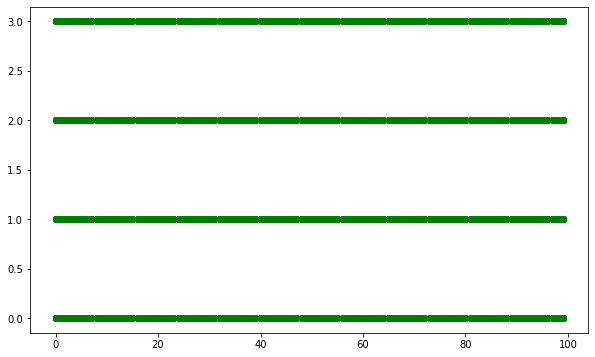

In [25]:
# gamma mean = 10
import ast
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(vehicle_limit):
#     route_list = ast.literal_eval(utility_df.Routes_taken.to_list()[i])
    route_list = utility_df.Routes_taken.to_list()[i]
    ax.scatter(range(rounds), route_list, alpha=0.5, color='g')
    
# ax.show()

# Others

In [26]:
# from scipy.io import loadmat
# eta_data = loadmat('data_mapEtas.mat')

# eta_data["mapEtaVals"]